In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.utils.data import DataLoader, Dataset
import requests
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

######Load Tiny Shakespeare dataset
def load_shakespeare():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    response = requests.get(url)
    text = response.text
    return text[:500000]

text = load_shakespeare()
print(f"Dataset Loaded: {len(text)} characters")

#Character encoding
chars = sorted(list(set(text)))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
encoded_text = [char_to_idx[c] for c in text]

#Dataset class
class CharDataset(Dataset):
    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length
        self.data = [text[i: i + seq_length] for i in range(len(text) - seq_length)]
        self.labels = [text[i + seq_length] for i in range(len(text) - seq_length)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

#####Model definitions
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

class CharGRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.gru(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

#####Training function
def train_model(model, dataset, seq_length, num_epochs=10, batch_size=64, lr=0.002):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    start_time = time.time()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            hidden = None

            optimizer.zero_grad()
            outputs, _ = model(inputs, hidden)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')
    print(f'Training Time: {time.time() - start_time:.2f} seconds')

#####Define parameters
seq_lengths = [20, 30, 50]
hidden_size = 128
num_layers = 2
batch_size = 64
num_epochs = 10
lr = 0.002

#####Train models for different sequence lengths
for seq_length in seq_lengths:
    print(f"\nTraining LSTM Model with Sequence Length {seq_length}:")
    dataset = CharDataset(encoded_text, seq_length)
    lstm_model = CharLSTM(len(chars), hidden_size, num_layers)
    train_model(lstm_model, dataset, seq_length, num_epochs, batch_size, lr)

    print(f"\nTraining GRU Model with Sequence Length {seq_length}:")
    gru_model = CharGRU(len(chars), hidden_size, num_layers)
    train_model(gru_model, dataset, seq_length, num_epochs, batch_size, lr)


Dataset Loaded: 500000 characters

Training LSTM Model with Sequence Length 20:
Epoch [1/10], Loss: 1.7651
Epoch [2/10], Loss: 1.5165
Epoch [3/10], Loss: 1.4554
Epoch [4/10], Loss: 1.4213
Epoch [5/10], Loss: 1.4004
Epoch [6/10], Loss: 1.3855
Epoch [7/10], Loss: 1.3732
Epoch [8/10], Loss: 1.3643
Epoch [9/10], Loss: 1.3570
Epoch [10/10], Loss: 1.3509
Training Time: 287.99 seconds

Training GRU Model with Sequence Length 20:
Epoch [1/10], Loss: 1.7496
Epoch [2/10], Loss: 1.5759
Epoch [3/10], Loss: 1.5511
Epoch [4/10], Loss: 1.5429
Epoch [5/10], Loss: 1.5445
Epoch [6/10], Loss: 1.5459
Epoch [7/10], Loss: 1.5530
Epoch [8/10], Loss: 1.5629
Epoch [9/10], Loss: 1.5689
Epoch [10/10], Loss: 1.5789
Training Time: 281.68 seconds

Training LSTM Model with Sequence Length 30:
Epoch [1/10], Loss: 1.7594
Epoch [2/10], Loss: 1.5074
Epoch [3/10], Loss: 1.4453
Epoch [4/10], Loss: 1.4129
Epoch [5/10], Loss: 1.3915
Epoch [6/10], Loss: 1.3750
Epoch [7/10], Loss: 1.3627
Epoch [8/10], Loss: 1.3535
Epoch [9/10

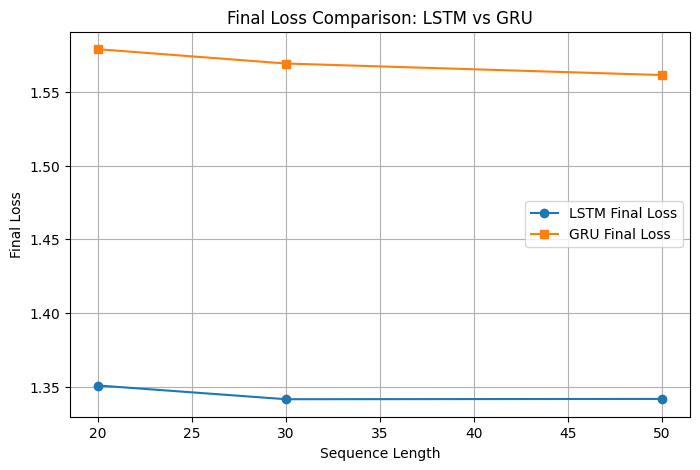

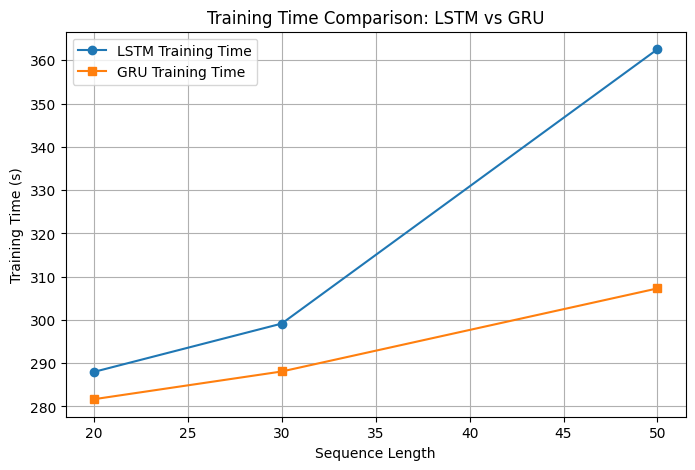

In [4]:
import matplotlib.pyplot as plt

# Data from training results
seq_lengths = [20, 30, 50]
lstm_final_loss = [1.3509, 1.3416, 1.3418]
gru_final_loss = [1.5789, 1.5692, 1.5614]
lstm_training_time = [287.99, 299.16, 362.57]
gru_training_time = [281.68, 288.09, 307.29]

# Plot loss comparison
plt.figure(figsize=(8, 5))
plt.plot(seq_lengths, lstm_final_loss, marker='o', linestyle='-', label='LSTM Final Loss')
plt.plot(seq_lengths, gru_final_loss, marker='s', linestyle='-', label='GRU Final Loss')
plt.xlabel("Sequence Length")
plt.ylabel("Final Loss")
plt.title("Final Loss Comparison: LSTM vs GRU")
plt.legend()
plt.grid()
plt.show()

# Plot training time comparison
plt.figure(figsize=(8, 5))
plt.plot(seq_lengths, lstm_training_time, marker='o', linestyle='-', label='LSTM Training Time')
plt.plot(seq_lengths, gru_training_time, marker='s', linestyle='-', label='GRU Training Time')
plt.xlabel("Sequence Length")
plt.ylabel("Training Time (s)")
plt.title("Training Time Comparison: LSTM vs GRU")
plt.legend()
plt.grid()
plt.show()
